# Dots and Boxes

In [3]:
import matplotlib.pyplot as plt 
from matplotlib import collections as mc
def drawlattice(n,name):
    for i in range(1,n+1):
        plt.plot(1,i,'o',c = 'black')
    plt.savefig(name)
    plt.show()

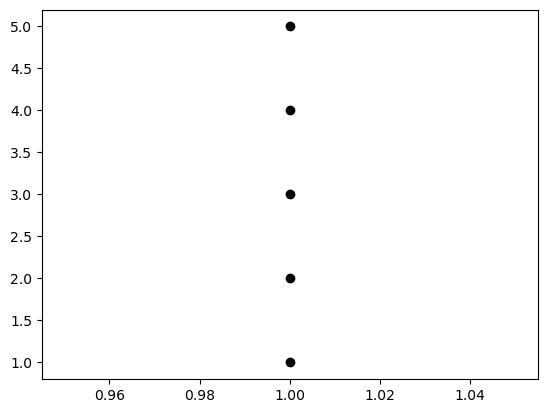

In [4]:
drawlattice(5,'lattice.png')

Now this filled just one line, we have to draw a grid for the game so we will do just that

In [11]:
game = [[(1,2),(1,1)],[(3,3),(4,3)],[(1,5),(2,5)],[(1,2),(2,2)],[(2,2),(2,1)],[(1,1),(2,1)], [(3,4),(3,3)],[(3,4),(4,4)]]
def drawgame(n,name,game):
    colors2 = []
    for k in range(0,len(game)):
        if k%2 == 0:
            colors2.append('red')
        else:
            colors2.append('blue')
    lc = mc.LineCollection(game, colors = colors2, linewidths = 2)
    fig, ax = plt.subplots()
    for i in range(1,n+1):
        for j in range(1,n+1):
            plt.plot(i,j,'o',c='black')
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.savefig(name)
    plt.show()

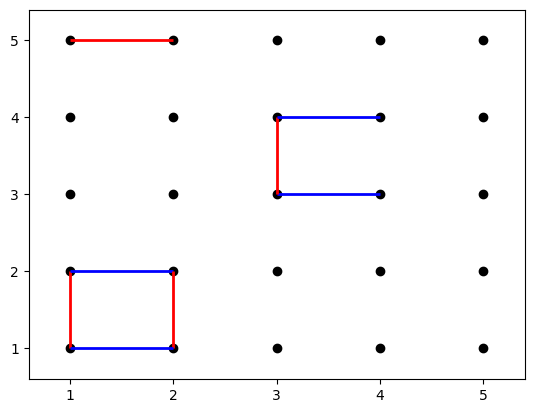

In [12]:
drawgame(5,'gameinprogress.png',game)

Now we will create a function that can keep score for dots and boxes game.
We start with a function that can take any given game and find the completed squares that have been drawn, and then we create a function that will calculate the score.
Our function will count completed squares by iterating over every line segment in the game. If a line is a horizontal line, we determine whether it is the top of a completely drawn square by checking whether the parellel line below it has also been drawn in the game, and also whether the left and right sides of the square have been drawn

In [26]:
def squarefinder(game):
    countofsquares = 0
    for line in game:
        parallel = False
        left = False 
        right = False
        if line[0][1] == line[1][1]:
            if[(line[0][0], line[0][1]-1), (line[1][0], line[1][1]-1)] in game:
                parallel = True
            if[(line[0][0], line[0][1]), (line[1][0] - 1, line[1][1]-1)] in game:
                left = True
            if[(line[0][0]+1, line[0][1]), (line[1][0], line[1][1]-1)] in game:
                right = True
            if parallel and left and right:
                countofsquares += 1
                
    return countofsquares

now we can write a short function to calculate the score of the game

the score will be recorded as a list with 2 elements, like [2,1]. The first element of the score list represents the score of the frst player and scnd element is score of the scnd player.

In [15]:
def score(game):
    score = [0,0]
    progress = []
    squares = 0
    for line in game:
        progress.append(line)
        newsquares = squarefinder(progress)
        if newsquares > squares:
            if len(progress)%2 == 0:
                score[1] = score[1]+1
            else:
                score[0] = score[0]+1
        squares = newsquares
    return score

# Building our tree

In [21]:
def generateTree(possible_moves, depth, maxdepth):
    tree = []
    for move in possible_moves:
        move_profile = [move]
        if depth<maxdepth:
            possible_moves2 = possible_moves.copy()
            possible_moves2.remove(move)
            move_profile.append(generateTree(possible_moves2, depth+1, maxdepth))
        tree.append(move_profile)
    return tree

function iterates over every possible move. For each move it creates a move_profile. at first, the move_profile consists only of the move itself. But for branches that are not yet at the lowest depth of the tree, we need to add those moves' children. We add children recursively: we call the generate_tree() function again, but now we have removed one move from the possible_moves list. Finally we append the move_profile list to the tree.


In [22]:
allpossible = [[(4,4),(4,3)],[(4,1),(5,1)]]
thetree = generateTree(allpossible,0,1)
print(thetree)

[[[(4, 4), (4, 3)], [[[(4, 1), (5, 1)]]]], [[(4, 1), (5, 1)], [[[(4, 4), (4, 3)]]]]]


next we will make 2 additions to moke our tree more useful:
    
    the first records the game score along with the moves
    the second appends a blank list to keep a place for children

In [24]:
def generate_tree(possible_moves,depth,maxdepth,game_so_far):
    tree = []
    for move in possible_moves:
        move_profile = [move]
        game2 = game_so_far.copy()
        game2.append(move)
        move_profile.append(score(game2))
        if depth < maxdepth:
            possible_moves2 = possible_moves.copy()
            possible_moves2.remove(move)
            move_profile.append(generate_tree(possible_moves2,depth + 1,maxdepth,game2))
        else:
            move_profile.append([])
        tree.append(move_profile)
    return tree

In [27]:
allpossible = [[(4,4),(4,3)],[(4,1),(5,1)]]
thetree = generate_tree(allpossible,0,1,[])
print(thetree)

[[[(4, 4), (4, 3)], [0, 0], [[[(4, 1), (5, 1)], [0, 0], []]]], [[(4, 1), (5, 1)], [0, 0], [[[(4, 4), (4, 3)], [0, 0], []]]]]


# Winning a game

Our decision in the present is about maximizing our score. But
in order to maximize our score, we have to consider all the ways that our
opponent will try to minimize our score. So the best choice is a maximum
of minima.
Note that minimax goes through time in reverse. The game proceeds
forward in time, from the present to the future. But in a way, the minimax
algorithm proceeds backward in time, because we consider the scores of
possible far futures first and then work our way back to the present to find
the current choice that will lead to the best future. In the context of our
game tree, the minimax code starts at the top of the tree. It calls itself
recursively on each of its child branches. The child branches, in turn, call
minimax recursively on their own child branches. This recursive calling
continues all the way to the terminal nodes, where, instead of calling mini-
max again, we calculate the game score for each node. So we’re calculating
the game score for the terminal nodes first; we’re starting our game score
calculations in the far future. These scores are then passed back to their
parent nodes so that the parent nodes can calculate the best moves and
corresponding score for their part of the game. These scores and moves
are passed back up through the game tree until arriving back at the very
top, the parent node, which represents the present.
Listing 10-6 has a function that accomplishes minimax.

In [28]:
import numpy as np
def minimax(max_or_min, tree):
    allscores = []
    for move_profile in tree:
        if move_profile[2] == []:
            allscores.append(move_profile[1][0] - move_profile[1][1])
        else:
            move, score = minimax((-1)*max_or_min, move_profile[2])
            allscores.append(score)
    newlist = [score*max_or_min for score in allscores]
    bestscore = max(newlist)
    bestmove = np.argmax(newlist)
    return(bestmove, max_or_min*bestscore)

In [29]:
thetree = generate_tree(allpossible, 0,3,game)

In [30]:
move,score = minimax(1, thetree)

In [31]:
print(thetree[move][0])

[(4, 4), (4, 3)]
